In [119]:
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models import TfidfModel
from gensim.similarities import SoftCosineSimilarity
import pandas as pd

user = "64EA9B6D-AA62-ED11-B67D-D85ED3AE4DFE"

df = pd.read_csv('./results4.csv')
df.columns = ['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags']

for i in range(0, len(df)):
    df['topics'][i] = df['topics'][i].replace("'',", "")
df['topics'] = df['topics'].apply(lambda x: x[1:-1].split(', '))

userDF = pd.DataFrame(columns=['id', 'topics',])
userDF.id = df.id.unique()
#add all unique topics to userDF by id unless it is empty
for i in range(0, len(userDF)):
    userDF['topics'][i] = df[df['id'] == userDF['id'][i]]['topics'].sum()
    userDF['topics'][i] = [x for x in userDF['topics'][i] if x != "\'\'"]
    
userDF['topics'].to_csv('./test.csv', index=False)

#change sentiment 4 to 1
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 4 else x)

#for each topic add sentiment based on mean of sentiment of the user's tweets with that topic
for i in range(0, len(userDF)):
    for j in range(0, len(userDF['topics'][i])):
        userDF['topics'][i][j] = userDF['topics'][i][j] + str((df[(df['id'] == userDF['id'][i]) & (df['topics'].apply(lambda x: userDF['topics'][i][j] in x))]['sentiment'].mean()).round(2))

userDF['topicsRaw'] = pd.read_csv('./test.csv')['topics']

#convert array of topicsRaw to string
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: str(x))

#clean topicsRaw and convert to array
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x.replace("\"", ""))
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x[1:-1].split(', '))

#using soft cosine similarity return 10 most similar users to a given user
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
documents = userDF['topics']
dictionary = Dictionary(documents)
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
index = WordEmbeddingSimilarityIndex(fasttext_model300)
sims = SparseTermSimilarityMatrix(index, dictionary)
model = SoftCosineSimilarity(bow_corpus, sims, num_best=10)

def get_recommendations(id):
    idx = userDF.index[userDF['id'] == id][0]
    query = userDF['topics'][idx]
    query = dictionary.doc2bow(query)
    return model[query]

#get closest users to the given user to predict sentiment towards a topic
results = get_recommendations(user)

#only use users with a distance of less than 0.3
results = [x for x in results if x[1] < 0.3]

#assign user{number} to each user
userDF['user'] = ["user" + str(i) for i in range(0, len(userDF))]
userDF['userNum'] = [str(i) for i in range(0, len(userDF))]

print("Closest users to", userDF.loc[userDF['id'] == user, 'user'].iloc[0], "are:", [userDF['user'][x[0]] for x in results], "with distances of:", [x[1] for x in results])

#get the most common topic for these users which the given user has not tweeted about
topic = max([x for y in [userDF['topicsRaw'][x[0]] for x in results] for x in y if x not in userDF['topicsRaw'][userDF.index[userDF['id'] == user][0]]], key = [x for y in [userDF['topicsRaw'][x[0]] for x in results] for x in y if x not in userDF['topicsRaw'][userDF.index[userDF['id'] == user][0]]].count)

#get mean sentiment of each of the closest users tweets with this topic
for i in range(0, len(results)):
    results[i] = (results[i][0], results[i][1], df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: topic in x))]['sentiment'].mean())

#predict chosen user's sentiment towards the topic using the mean sentiment of the closest users tweets with the topic if not NAN
meanSentiment = sum([x[2] for x in results if not pd.isnull(x[2])]) / len([x[2] for x in results if not pd.isnull(x[2])])

print(topic, meanSentiment)

if(meanSentiment > 0.8):
    print("positive")
elif(meanSentiment > 0.6):
    print("mostly positive")
elif(meanSentiment > 0.4):
    print("neutral")
elif(meanSentiment > 0.2):
    print("mostly negative")
else:
    print("negative")

C:\Users\andre\AppData\Local\Temp\ipykernel_5508\779311163.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1483/1483 [00:00<00:00, 329004.17it/s]
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning:

divide by zero encountered in divide

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning:

invalid value encountered in multiply



Closest users to user8 are: ['user4', 'user7', 'user6', 'user5', 'user3', 'user12', 'user13', 'user9', 'user0'] with distances of: [0.16300992667675018, 0.13316181302070618, 0.11573655158281326, 0.09424948692321777, 0.08726988732814789, 0.08618536591529846, 0.08196184039115906, 0.06876741349697113, 0.057414405047893524]
'Trump' 0.25854700854700857
mostly negative


In [99]:
#plot a chart showing user Id, mean sentiment of tweets with topic, distance from given user, and number of tweets with topic

combDF = pd.DataFrame(results, columns=['user', 'distance', 'mean'])

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['User', 'Mean Sentiment', 'Distance', 'Number of Tweets with Topic']),
                    cells=dict(values=[combDF['user'], combDF['mean'], combDF['distance'], [len(df[(df['id'] == userDF['id'][x]) & (df['topics'].apply(lambda x: topic in x))]) for x in combDF['user']]]))
                ])
fig.show()

In [111]:
#graph showing the closest users to the given user and their sentiment towards the mean if not NAN

import plotly.express as px

fig = go.Figure()

fig.update_layout(
    title="Sentiment towards " + topic + " by closest users to " + userDF.loc[userDF['id'] == user, 'user'].iloc[0],
    xaxis_title="User",
    yaxis_title="Sentiment",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.add_trace(go.Scatter(x=combDF['user'], y=combDF['mean'], mode='markers', name='Closest Users'))
fig.add_trace(go.Scatter(x=[userDF.loc[userDF['id'] == user, 'userNum'].iloc[0]], y=[meanSentiment], mode='markers', name='Chosen User'))

fig.show()

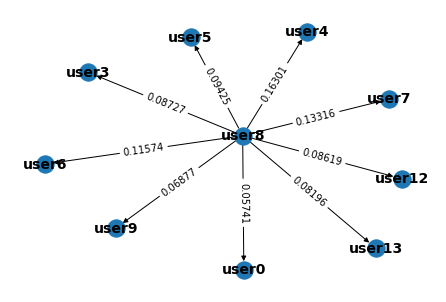

In [113]:
#directed graph showing the closest users to the given user and their distance from the given user

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_node(userDF.loc[userDF['id'] == user, 'user'].iloc[0])

for i in range(0, len(results)):
    G.add_node(userDF['user'][results[i][0]])
    G.add_edge(userDF.loc[userDF['id'] == user, 'user'].iloc[0], userDF['user'][results[i][0]], weight=results[i][1].round(5))
    
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', font_size=14)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [40]:
#plot a chart showing the closest users sentiment towards the topic over each tweet

import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    title="Sentiment towards " + topic + " by closest users to " + userDF.loc[userDF['id'] == user, 'user'].iloc[0],
    xaxis_title="Tweet",
    yaxis_title="Sentiment",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

for i in range(0, len(results)):
    fig.add_trace(go.Scatter(x=[x for x in range(0, len(df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: topic in x))]))], y=df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: topic in x))]['sentiment'], mode='lines', name=userDF['user'][results[i][0]]))
    
fig.show()

In [121]:
print(userDF['user'][0])
print(combDF['user'][0])

user0
4
